# Intel Image Classification

In this project, we will be working on Intel images i.e. images of buildings, forest, street, etc. We will built a convolutional neural network and train it on this images. This is a multi class classification problem and we will use Keras.

First we will mount our google drive on colab so that we can use the dataset directly from our drive. For this you first need to upload the data on your drive and then mount the drive on colab.

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


After mounting our drive we will locate the folder where our data is stored to use it in our colab notebook. Here we will see all the folders I have in my drive and 'Intel Image Dataset' contains the images that we will work on.

In [2]:
# After executing the cell above, Drive files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

 11.10.2022.ParthKalkar.WeeklyReport.docx
'academic transcript.pdf'
 archive.zip
 card.jpg
'Colab Notebooks'
'Copy of 11.11.2022.ParthKalkar.WeeklyReport.docx'
'Copy of ParthKalkar_CV.docx'
'Copy of ParthKalkar_CV.docx.pdf'
'Copy of PIRATE KING Resume - Dark.gdoc'
'Copy of PIRATE KING Resume - White.gdoc'
'Copy of Reference letter_Germany - Elvina.gdoc'
 CoverLetter.gdoc
'Cover Letter Template + Resources.gdoc'
'Data Science Practice.gdoc'
 final_SOP.docx
 Google-Docs-Invoice-Template-SC-2-G.docx
'HABRN - Communication Assignment.gdoc'
'HABRN - Emotion Assignment.gdoc'
'HABRN - Movement and Training Assignment.gdoc'
'How to get started with Drive.pdf'
'IMDB Dataset.csv'
 IMG_20220829_144022_434.jpg
'Intel Image Dataset'
'Interview preparation.gdoc'
 Letter.gdoc
'Masters University.gdoc'
'Material for SLR.gdoc'
'Migration Certificate .pdf'
'MS Admission Enquiry Letter.gdoc'
'Online Food Industry Market research.gdoc'
'ParthKalkar_CV (1).pdf'
 ParthKalkar_CV.docx
 ParthKalkar_CV.pdf
'Par

We will start by importing some required libraries.

In [6]:
# Important imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from sklearn.preprocessing import  LabelBinarizer
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array, array_to_img
from keras.optimizers import Adam
from PIL import Image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, LeakyReLU
from sklearn.model_selection import train_test_split

We will check for folders of class images.

In [7]:
# Listing directory
!ls "/content/drive/MyDrive/Intel Image Dataset"

buildings  forest  glacier  mountain  sea  street


Let's visualize some of the mountain images that we will be working on. Also we will observe x and y dimensions of the image.

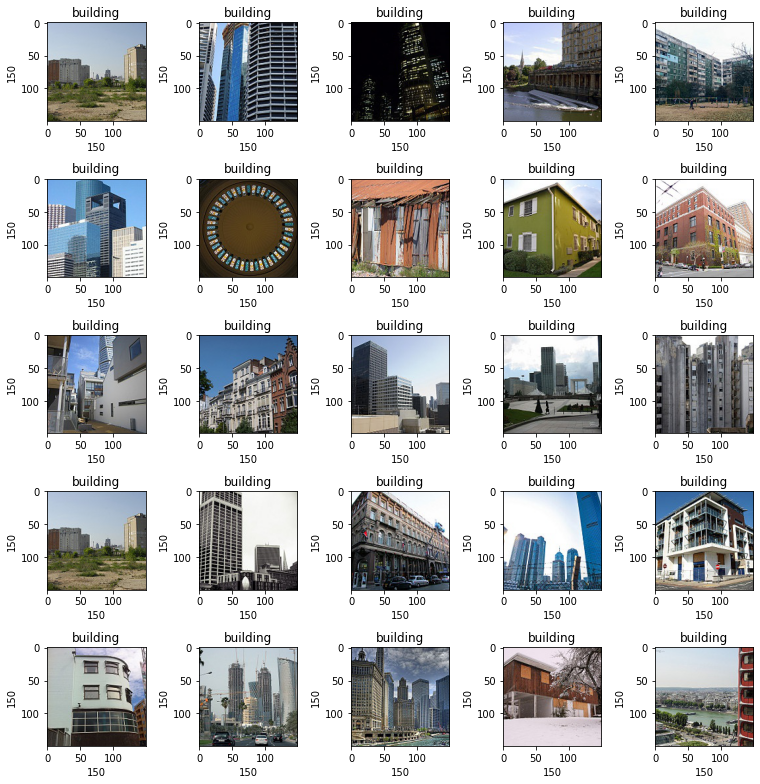

In [10]:
# Plotting 25 images to check dataset
plt.figure(figsize=(11,11))
path = "/content/drive/MyDrive/Intel Image Dataset/buildings"
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(listdir(path))))
    plt.imshow(rand_img)
    plt.title('building')
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

Setting the root directory for the dataset and storing all the folders name of the dataset. We will also create 2 empty list for image and lables.

In [11]:
# Setting root directory path and creating empty list
dir = "/content/drive/MyDrive/Intel Image Dataset"
root_dir = listdir(dir)
image_list, label_list = [], []

Next we need to resize images as some of the images don't have same dimensions. So, we will read and resize all the images. Then we will convert it into array and appending the list created above with the image and its label.

In [12]:
# Reading and converting image to numpy array
for directory in root_dir:
  for files in listdir(f"{dir}/{directory}"):
    image_path = f"{dir}/{directory}/{files}"
    image = Image.open(image_path)
    image = image.resize((150,150)) # All images does not have same dimension
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

Checking for images per class.

In [13]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

glacier      553
mountain     525
sea          510
street       501
forest       474
buildings    437
dtype: int64

Storing the number of classes which will be used further in model architecture.

In [14]:
# Checking count of classes
num_classes = len(label_counts)
num_classes

6

Check the shape of the x data for input layer of model architecture.

In [15]:
# Checking x data shape
np.array(image_list).shape

(3000, 150, 150, 3)

Checking the number of labels in y data which should be equal to total number of images.

In [16]:
# Checking y data shape
label_list = np.array(label_list)
label_list.shape

(3000,)

Now we will split our dataset into testing and training using train_test_split() from sklearn.

In [17]:
# Splitting dataset into test and train
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10) 

Next we will normalize the images by dividing them with 255 and we will also reshape x_train and x_test data. 

In [18]:
# Normalize and reshape data
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 150,150,3)
x_test = x_test.reshape( -1, 150,150,3)

Here we will use label binarizer to one hot encode our y data. We will also print the sequence of the classes.

In [19]:
# Binarizing labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Now we will split the training data to validation and training data.

In [20]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Now we will create a network architecture for the model. We have used different types of layers according to their features namely BatchNormalization (Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch), LeakyRelu (The Leaky ReLU modifies the function to allow small negative values when the input is less than zero), Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel). In the last layer we will use softmax as the activation function because it is a multi class classification problem.

In [21]:
# Creating model architecture
model = Sequential([
        Conv2D(16, kernel_size = (3,3), input_shape = (150,150,3)),
        BatchNormalization(),
        LeakyReLU(),
          
        Conv2D(32, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),
        
        Conv2D(64, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2D(128, kernel_size = (3,3)),
        BatchNormalization(),
        LeakyReLU(),
        MaxPooling2D(5,5),

        Flatten(),
    
        Dense(64),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
        
        Dense(32),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(),
    
        Dense(16),
        Dropout(rate = 0.2),
        BatchNormalization(),
        LeakyReLU(1),
    
        Dense(6, activation = 'softmax')    
        ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 16)     64        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 148, 148, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 146, 146, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 146, 146, 32)      0

For compiling the model we need to pass 3 parameters namely loss, optimizer and metrics. Here we will use loss as categorical_crossentropy, optimizer as Adam and metrics as accuracy.

In [22]:
# Compiling model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0005),metrics=['accuracy'])

Fitting the model with the data and finding out the accuracy at each epoch to see how our model is learning. Now we will train our model on 70 epochs and a batch size of 128. You can try using more number of epochs to increase accuracy. During each epochs we can see how the model is performing by viewing the training and validation accuracy.

In [23]:
# Training the model
epochs = 70
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/70
15/15 [==============================] - 15s 249ms/step - loss: 1.5048 - accuracy: 0.4104 - val_loss: 1.8239 - val_accuracy: 0.1854
Epoch 2/70
15/15 [==============================] - 2s 155ms/step - loss: 1.1289 - accuracy: 0.5734 - val_loss: 2.1429 - val_accuracy: 0.1854
Epoch 3/70
15/15 [==============================] - 2s 161ms/step - loss: 0.9690 - accuracy: 0.6479 - val_loss: 2.4015 - val_accuracy: 0.1854
Epoch 4/70
15/15 [==============================] - 2s 143ms/step - loss: 0.9105 - accuracy: 0.6729 - val_loss: 2.2905 - val_accuracy: 0.1854
Epoch 5/70
15/15 [==============================] - 2s 143ms/step - loss: 0.8128 - accuracy: 0.7156 - val_loss: 2.3965 - val_accuracy: 0.1854
Epoch 6/70
15/15 [==============================] - 2s 149ms/step - loss: 0.7800 - accuracy: 0.7333 - val_loss: 2.5015 - val_accuracy: 0.1854
Epoch 7/70
15/15 [==============================] - 2s 142ms/step - loss: 0.6907 - accuracy: 0.7714 - val_loss: 2.3403 - val_accuracy: 0.1875
Epoch

We will save the model using model.save() to use it later for prediction.

In [24]:
# Saving model
model.save("/content/drive/MyDrive/Intel Image Dataset/intel_image.h5")

Next we will plot the accuracy of the model for the training history.



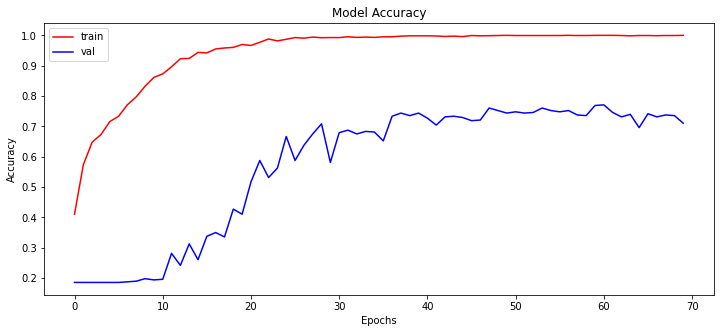

In [25]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

Next we will plot the loss of the model for the training history.



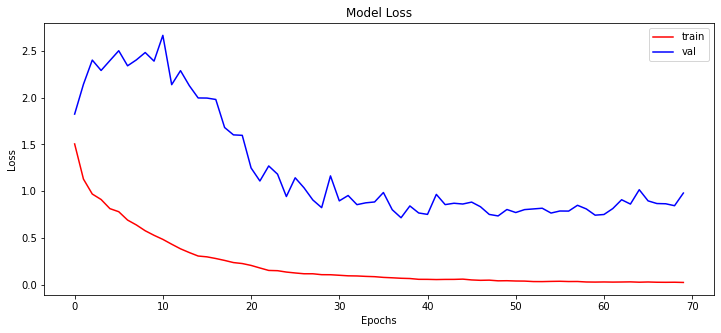

In [26]:
#Plot the loss history
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

Evaluating the model to know the accuracy of the model on the test data.

In [27]:
# Calculating test accuracy 
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

19/19 [==============================] - 1s 21ms/step - loss: 0.9288 - accuracy: 0.7167
Test Accuracy: 71.66666388511658


Generating predictions for test data and storing them into y_pred.

In [28]:
# Storing model predictions
y_pred = model.predict(x_test)

19/19 [==============================] - 0s 13ms/step


Visualizing an image to be predicted in further steps.

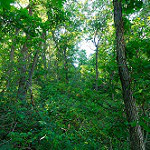

In [29]:
# Plotting image to compare
img = array_to_img(x_test[1])
img

Now, we will create list of labels using object of label binarizer. We will print that list and finally we will print out the prediction and the original label of the image we visualized above using argmax().

In [30]:
# Finding max value from predition list and comaparing original value vs predicted
labels = lb.classes_
print(labels)
print("Originally : ",labels[np.argmax(y_test[1])])
print("Predicted : ",labels[np.argmax(y_pred[1])])

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
Originally :  forest
Predicted :  forest


## Conclusion:

In this project we saw how we can create a CNN using different layers. Normalizing is an important step when working with any type of dataset. We will use this model to predict the class of the image supplied to the model.

## Scope:

This project has a vast scope, it can be used to classify satellite images, drone images, google images into different classes like sea, mountain, etc. 